In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import seaborn as sns
import pickle
import h5py
import xlrd
import xlwt
import heapq
import maskdb_parsing as maskdb
import nibabel as nib
from sklearn.decomposition import PCA
from scipy.stats import norm
from matplotlib import gridspec

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [1070]:
import matplotlib
print (matplotlib.__version__)

3.4.3


## Selective Breeding analysis

In [2]:
df_behavior = pd.read_excel('/Users/jialexu/Desktop/Project4SelectiveBreeding/experiment/SDA_VDA_selection/data/SB_summary.xlsx')


In [3]:
df_behavior = df_behavior.set_index('Fish_id')

In [4]:
df_behavior_norm = df_behavior.loc[~df_behavior['Z_number'].isin(['Z3374','Z3663'])]
df_temp_list=[]
for Generation in df_behavior_norm['Generation'].unique():
    df_temp = df_behavior_norm.loc[df_behavior_norm['Generation']==Generation]['Mean_LDCI']
    df_temp = (df_temp-df_temp.mean())/df_temp.std()
    df_temp_list.append(df_temp)
df_behavior_norm = pd.concat((df_behavior_norm[['Generation','Category']],
                             pd.concat(df_temp_list)),axis=1)

In [5]:
df_behavior_norm = df_behavior.copy()
df_behavior_norm['norm_LDCI'] = (df_behavior_norm['Mean_LDCI']-df_behavior_norm['Mean_LDCI'].mean())/df_behavior_norm['Mean_LDCI'].std()
df_behavior_norm = df_behavior_norm.loc[~df_behavior_norm['Z_number'].isin(['Z3374','Z3663'])]


In [6]:
wdir = '/Users/jialexu/Desktop/Project4SelectiveBreeding/experiment/LD_behavior_test/'
file_list = []
for file in os.listdir(wdir):
    if file.startswith('202'):
        file_list+=(os.listdir(wdir+file+'/'))

arenafiles = []
binfiles = []
zonefiles = []
for file in file_list:
    if 'Arena' in file:
        arenafiles.append(file)
    elif 'Bin' in file:
        binfiles.append(file)
    elif 'Zone' in file:
        zonefiles.append(file)

In [7]:
arena_dfs = []
arena_dfs_1 = []
for file in arenafiles:
    date = file.split('-')[-1].split('.')[0]
    df = pd.read_excel(wdir+date+'/'+file)
    df['date'] = date
    if df.iloc[0,0] != 'Result 1':
        df.columns = df.iloc[1,:]
        df.rename(columns = {df.columns[-1]:'date'},inplace=True)
        arena_dfs_1.append(df.iloc[3:,:].reset_index())
    else:
        arena_dfs.append(df)
df_arena_raw = pd.concat(arena_dfs)

In [8]:
df_arena = df_arena_raw.copy()
columns1 = df_arena.loc[:,df_arena.columns.str.contains('Independent Variable Independent Variable')].columns 
for column in columns1:
    keyword = column.split(' ')[-1]
    print(keyword)
    if keyword in ['Pcolumn', 'Plate', 'Prow', 'Trial', 'Well']:
        df_arena.rename(columns={column:keyword},inplace=True)
    else:
        df_arena.drop(column,axis=1)


df_arena.reset_index(inplace=True)

#df_arena = df_arena.loc[df_arena['Plate'].dropna().index]

Pcolumn
Pedigree
Plate
Prow
Trial
Well
comment
Gene
Treatment
Notes
Comments
Optical_genotype
1>
Cat


In [9]:
df_arena['Fish_id'] = df_arena['date']+'-Plate'+df_arena['Plate'].apply(lambda x:str(round(x)))+\
                    '-'+df_arena['Pcolumn'].apply(lambda x:str(round(x)))+df_arena['Prow']

df_arena = pd.concat((df_arena['Fish_id'],df_arena.iloc[:,4:20]),axis=1)


In [10]:
df_arena = df_arena.set_index('Fish_id')

df_arena = df_arena.loc[~(df_arena['In zone D / center-point Cumulative Duration s']=='-')]

df_arena['adj_d_zone_duration'] = 480*df_arena['In zone D / center-point Cumulative Duration s'].astype(float)/\
                        (df_arena['In zone D / center-point Cumulative Duration s'].astype(float)+df_arena['In zone L / center-point Cumulative Duration s'].astype(float))



df_arena['Trial_LDCI'] = (df_arena['adj_d_zone_duration']*2-480)/480

def ADED(duration, frequency):
    if frequency == 0:
        return 0
    else:
        return (duration/frequency)
    
df_arena['In zone L / center-point Frequency'] = df_arena['In zone L / center-point Frequency'].astype(float)


df_arena['ADED'] = df_arena[['adj_d_zone_duration','In zone D / center-point Frequency']].\
            apply(lambda x: ADED(x['adj_d_zone_duration'], x['In zone D / center-point Frequency']),axis=1)



df_arena['LFDE'] = df_arena['In zone D / center-point Latency to First s'].apply(lambda x: 480 if x=='-' else x)


df_arena['TDEN'] = df_arena['In zone D / center-point Frequency']

df_arena['Velocity'] = df_arena['Velocity center-point Mean mm/s']
df_arena['TD'] = df_arena['Distance moved center-point Total mm']

df_arena_pro = df_arena.iloc[:,-7:].reset_index().groupby('Fish_id').mean()

In [11]:
df_arena_pro

,adj_d_zone_duration,Trial_LDCI,ADED,LFDE
Fish_id,,,,
20210723-Plate1-10A,51.889777,-0.783793,11.255406,163.493400
20210723-Plate1-10B,36.687169,-0.847137,5.074521,139.578303
20210723-Plate1-10C,67.989289,-0.716711,10.371259,169.299125
20210723-Plate1-10D,58.197143,-0.757512,7.445443,140.679500
20210723-Plate1-10E,94.431727,-0.606534,9.804801,47.029250
...,...,...,...,...
20230721-Plate2-9C,244.462478,0.018594,33.447213,0.517173
20230721-Plate2-9D,60.992561,-0.745864,10.164002,105.795443
20230721-Plate2-9F,238.059360,-0.008086,25.036254,20.853740


In [12]:
df_arena_raw_1 = pd.concat(arena_dfs_1)
df_arena_1 = df_arena_raw_1.copy()
df_arena_1['Plate'] = df_arena_1['Plate'].apply(lambda x:x[-1])

In [13]:
df_arena_1['Fish_id'] = df_arena_1['date']+'-Plate'+df_arena_1['Plate']+\
                    '-'+df_arena_1['Pcolumn']+df_arena_1['Prow']

In [14]:
df_arena_1 = pd.concat((df_arena_1['Fish_id'],df_arena_1.iloc[:,5:20]),axis=1)

In [15]:
df_arena_1 = df_arena_1.set_index('Fish_id')
df_arena_1 = df_arena_1.loc[~(df_arena_1.iloc[:,9]=='-')]


In [16]:
df_arena_1 = df_arena_1.loc[~(df_arena_1.iloc[:,12]=='-')]

In [17]:
df_arena_1['adj_d_zone_duration'] = 480*df_arena_1.iloc[:,8].astype(float)/\
                        (df_arena_1.iloc[:,8].astype(float)+df_arena_1.iloc[:,11].astype(float))


In [18]:
df_arena_1['Trial_LDCI'] = (df_arena_1['adj_d_zone_duration']*2-480)/480

def ADED(duration, frequency):
    if frequency == 0:
        return 0
    else:
        return (duration/frequency)

df_arena_1['ADED'] = df_arena_1.iloc[:,[15, 7]].apply(lambda x: ADED(x['adj_d_zone_duration'],x['Frequency']),axis=1)



df_arena_1['LFDE'] = df_arena_1.iloc[:,9].apply(lambda x: 480 if x=='-' else x)


df_arena_1['TDEN'] = df_arena_1.iloc[:,7]

df_arena_1['Velocity'] = df_arena_1.iloc[:,6]
df_arena_1['TD'] = df_arena_1.iloc[:,5]

df_arena_1_pro = df_arena_1.iloc[:,-7:].reset_index().groupby('Fish_id').mean()

In [19]:
df_arena['TDEN'] = df_arena['TDEN'].astype(int)
df_arena = df_arena.loc[~(df_arena['Velocity']=='-')]
df_arena['Velocity'] = df_arena['Velocity'].astype(float)
df_arena['TD'] = df_arena['TD'].astype(float)

In [20]:
df_arena_1['TDEN'] = df_arena_1['TDEN'].astype(int)
df_arena_1 = df_arena_1.loc[~(df_arena_1['Velocity']=='-')]
df_arena_1['Velocity'] = df_arena_1['Velocity'].astype(float)
df_arena_1['TD'] = df_arena_1['TD'].astype(float)

In [21]:
df_arena_1_pro = df_arena_1.iloc[:,-7:].reset_index().groupby('Fish_id').mean()
df_arena_pro = df_arena.iloc[:,-7:].reset_index().groupby('Fish_id').mean()

In [22]:
def zone_process(input_dir, file):  
    df_zone = pd.read_excel(input_dir+file)
    date = file.split('/')[-1].split('.')[0].split('_')[-1]
    df_zone['Fish_ID'] = df_zone.loc[:, (df_zone.columns.str.endswith('Pcolumn')|df_zone.columns.str.endswith('Prow'))].astype('str').agg(''.join, axis=1)
    df_zone['Fish_ID'] = date+'-'+'Plate'+df_zone.loc[:,(df_zone.columns.str.endswith('Plate')|df_zone.columns.str.endswith('Fish_ID'))].astype('str').agg('-'.join, axis=1)
    df_zone = df_zone.loc[:,['Unnamed: 3','Distance moved center-point Total mm','Fish_ID']]
    df_zone = df_zone.loc[df_zone['Unnamed: 3']=='In D'].iloc[:, 1:]
    df_zone.rename(columns={df_zone.columns[0]:'DZTD'}, inplace=True)
    df_zone.set_index('Fish_ID', inplace=True)
    df_zone.replace('-', 0, inplace=True)
    df_zone = df_zone.groupby('Fish_ID').mean()
    return df_zone

In [23]:
df_zone_list = []
for file in zonefiles:
    print(file)
    date = file.split('-')[-1].split('.')[0]
    df_zone_single = zone_process(wdir+date+'/',file)
    df_zone_list.append(df_zone_single)
    
df_zone = pd.concat(df_zone_list)
df_zone

ZoneWiseStatistics-20220413.xlsx
ZoneWiseStatistics-20221220.xlsx
ZoneWiseStatistics-20220301.xlsx
ZoneWiseStatistics-20221227.xlsx
ZoneWiseStatistics-20211014.xlsx
ZoneWiseStatistics-20220909.xlsx
SelectiveBreeding-ZoneWiseStatistics-20210504.xlsx
ZoneWiseStatistics-20210923.xlsx
ZoneWiseStatistics-20210723.xlsx
SelectiveBreeding-ZoneWiseStatistics-20210511.xlsx
SelectiveBreeding-ZoneWiseStatistics-20210128.xlsx
ZoneWiseStatistics-20220923.xlsx
ZoneWiseStatistics-20220315.xlsx
SelectiveBreeding-ZoneWiseStatistics-20210126.xlsx
ZoneWiseStatistics-20211007.xlsx
SelectiveBreeding-ZoneWiseStatistics-20210203.xlsx
ZoneWiseStatistics-20220420.xlsx
ZoneWiseStatistics-20220224.xlsx
ZoneWiseStatistics-20230302.xlsx
ZoneWiseStatistics-20211021.xlsx
ZoneWiseStatistics-20220927.xlsx
ZoneWiseStatistics-20230721.xlsx
ZoneWiseStatistics-20210917.xlsx
ZoneWiseStatistics-20220916.xlsx
ZoneWiseStatistics-20220201.xlsx
ZoneWiseStatistics-20211112.xlsx


,DZTD
Fish_ID,
ZoneWiseStatistics-20220413-Plate1-10A,190.204100
ZoneWiseStatistics-20220413-Plate1-10B,339.568000
ZoneWiseStatistics-20220413-Plate1-10C,155.962350
ZoneWiseStatistics-20220413-Plate1-10D,86.030250
ZoneWiseStatistics-20220413-Plate1-10E,64.693925
...,...
ZoneWiseStatistics-20211112-Plate2-9D,198.078250
ZoneWiseStatistics-20211112-Plate2-9E,335.951500
ZoneWiseStatistics-20211112-Plate2-9F,267.167880


In [24]:
df_zone_new = df_zone.copy()
    
df_zone_new1 = df_zone_new.loc[df_zone_new.index.str.split('-').str[0] == 'SelectiveBreeding']
df_zone_new2 = df_zone_new.loc[~(df_zone_new.index.str.split('-').str[0] == 'SelectiveBreeding')]

df_zone_new1.index = df_zone_new1.index.str.split('-',2).str[2]
df_zone_new2.index = df_zone_new2.index.str.split('-',1).str[1]
df_zone_new = pd.concat((df_zone_new1, df_zone_new2))

In [36]:
df_behavior.loc[df_arena_new.index]

,Z_number,Generation,Category,Mean_LDCI
Fish_id,,,,
20210128-Plate1-10A,Z_3280,1,EKW,-0.905908
20210128-Plate1-10B,Z_3280,1,EKW,-0.991147
20210128-Plate1-10C,Z_3280,1,EKW,-0.561861
20210128-Plate1-10E,Z_3280,1,EKW,-0.689631
20210128-Plate1-10F,Z_3280,1,EKW,-0.841490
...,...,...,...,...
20230721-Plate2-9C,Z3774,6,VDA,0.018594
20230721-Plate2-9D,Z3773,6,SDA,-0.745864
20230721-Plate2-9F,Z3774,6,VDA,-0.008086


In [37]:
df_arena_new = pd.concat((df_arena_1_pro,df_arena_pro))
df_arena_new = df_arena_new.loc[df_arena_new.index.isin(df_behavior_norm.index)]
df_arena_new = pd.concat((df_arena_new,
                          df_zone_new.loc[df_behavior_norm.index],
                          df_behavior.loc[df_arena_new.index].iloc[:,:-1]),axis=1)

In [182]:
df_arena_new.loc[df_arena_new['Generation']==1]['Trial_LDCI'].quantile(0.9)

-0.4184264771661787

In [39]:
df_behavior_norm = df_arena_new.copy()
for param in df_behavior_norm.columns[1:8]:

    df_behavior_norm[param+'_norm'] = (df_behavior_norm[param]-df_behavior_norm[param].mean())/df_behavior_norm[param].std()
    
df_behavior_norm = df_behavior_norm.loc[~df_behavior_norm['Z_number'].isin(['Z3374','Z3663'])]


df_behavior_norm

,adj_d_zone_duration,Trial_LDCI,ADED,LFDE,TDEN,Velocity,TD,DZTD,Z_number,Generation,Category,Trial_LDCI_norm,ADED_norm,LFDE_norm,TDEN_norm,Velocity_norm,TD_norm,DZTD_norm
Fish_id,,,,,,,,,,,,,,,,,,
20210128-Plate1-10A,30.109323,-0.874544,3.855143,176.039200,6.333333,3.720250,1770.923333,154.474000,Z_3280,1,EKW,-0.749243,-0.535490,-0.135130,0.110026,1.249690,1.164645,-0.373320
20210128-Plate1-10B,8.498816,-0.964588,1.699763,99.697600,5.000000,3.170890,1513.680000,10.680075,Z_3280,1,EKW,-1.092439,-0.646132,-0.791841,-0.228816,0.486849,0.428605,-1.092240
20210128-Plate1-10C,105.153467,-0.561861,6.702186,46.654000,15.750000,3.390073,1622.622500,416.278500,Z_3280,1,EKW,0.442532,-0.389343,-1.248136,2.503093,0.791206,0.740318,0.935613
20210128-Plate1-10E,99.318206,-0.586174,13.617929,59.791833,7.666667,3.311090,1585.323333,281.191525,Z_3280,1,EKW,0.349863,-0.034338,-1.135121,0.448867,0.681531,0.633595,0.260224
20210128-Plate1-10F,38.042351,-0.841490,4.782653,165.587125,4.750000,2.999062,1438.984500,134.430475,Z_3280,1,EKW,-0.623259,-0.487878,-0.225041,-0.292349,0.248249,0.214882,-0.473531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230721-Plate2-9C,244.462478,0.018594,33.447213,0.517173,8.750000,1.883738,917.149250,466.750000,Z3774,6,VDA,2.654898,0.983556,-1.645017,0.724176,-1.300492,-1.278225,1.187953
20230721-Plate2-9D,60.992561,-0.745864,10.164002,105.795443,6.750000,2.422007,1181.563750,142.734675,Z3773,6,SDA,-0.258787,-0.211638,-0.739385,0.215913,-0.553050,-0.521666,-0.432013
20230721-Plate2-9F,238.059360,-0.008086,25.036254,20.853740,12.500000,3.003392,1458.272500,647.875250,Z3774,6,VDA,2.553210,0.551797,-1.470076,1.677167,0.254262,0.270070,2.093517


In [40]:
stats_dic = {}
for generation in df_behavior_norm['Generation'].unique()[1:]:
    ttest_res_list = [] 
    for param in df_behavior_norm.loc[:,df_behavior_norm.columns.str.endswith('norm')].columns:
        x = df_behavior_norm.loc[(df_behavior_norm['Generation'] == generation)&(df_behavior_norm['Category']=='SDA')][param]
        x = x[(x>x.mean()-1.96*x.std())&(x<x.mean()+1.96*x.std())]
        y = df_behavior_norm.loc[(df_behavior_norm['Generation'] == generation)&(df_behavior_norm['Category']=='VDA')][param]
        y = y[(y>y.mean()-1.96*y.std())&(y<y.mean()+1.96*y.std())]
        pval = pg.ttest(x.sample(35),y.sample(35)).iloc[0,3]
        ttest_res_list.append(pval)
    stats_dic.update({generation:ttest_res_list})
df_stats = pd.DataFrame(stats_dic)
df_stats.index = df_behavior_norm.loc[:,df_behavior_norm.columns.str.endswith('norm')].columns
df_stats

,2,3,4,5,6
Trial_LDCI_norm,0.073193,0.000029,1.013488e-19,1.409561e-19,2.028590e-32
ADED_norm,0.015639,0.075143,3.613953e-12,9.657509e-13,2.070223e-13
LFDE_norm,0.000728,0.000002,1.406729e-17,1.743617e-18,5.351267e-21
TDEN_norm,0.000020,0.000649,1.353626e-11,1.670474e-10,5.208913e-19
Velocity_norm,0.109493,0.120309,1.462859e-01,1.542576e-01,1.245773e-02
TD_norm,0.473435,0.496067,9.250036e-01,8.385440e-01,1.004196e-03
DZTD_norm,0.095214,0.000004,1.981310e-19,2.829609e-17,3.988170e-21


In [41]:
def symbolize(x):
    if x>0.05:
        return 'ns'
    elif x>0.01:
        return '*'
    elif x>0.001:
        return '**'
    elif x>0.0001:
        return '*'*3
    else:
        return '*'*5

In [42]:
df_stats.applymap(lambda x: symbolize(x))

,2,3,4,5,6
Trial_LDCI_norm,ns,*****,*****,*****,*****
ADED_norm,*,ns,*****,*****,*****
LFDE_norm,***,*****,*****,*****,*****
TDEN_norm,*****,***,*****,*****,*****
Velocity_norm,ns,ns,ns,ns,*
TD_norm,ns,ns,ns,ns,**
DZTD_norm,ns,*****,*****,*****,*****


In [43]:
df_stats.to_csv(wdir+'stats_20230821.csv')

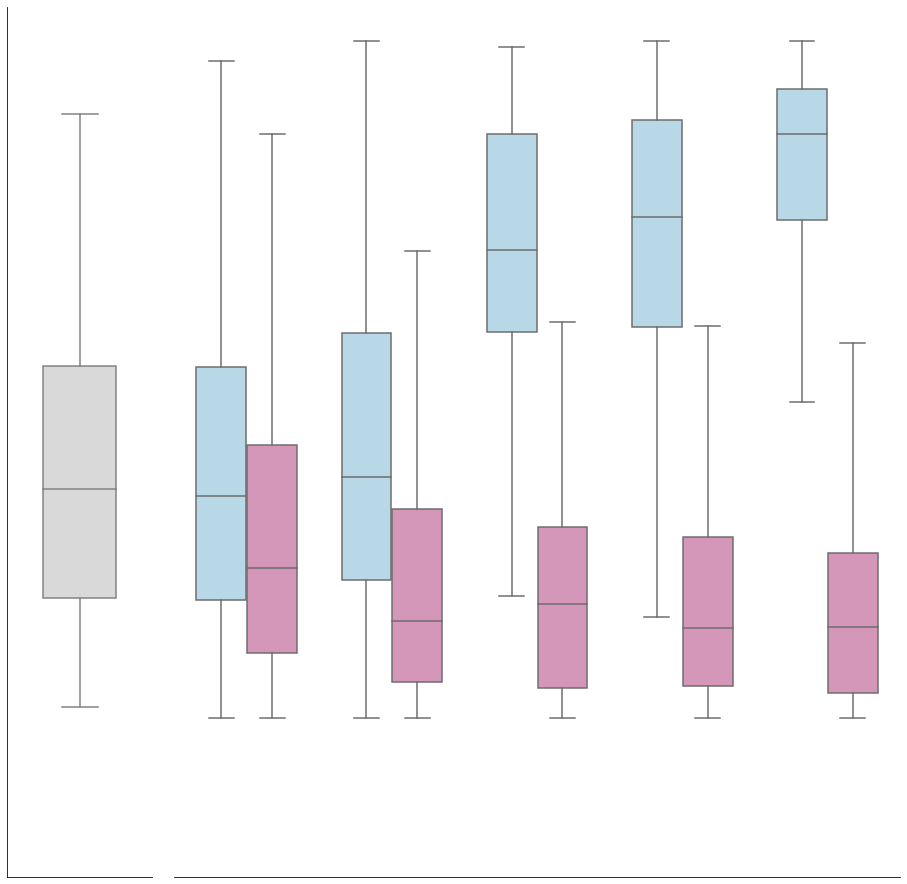

In [927]:
df_plot2 = df_behavior_norm.loc[df_behavior_norm['Generation']==1]
df_plot = df_behavior_norm.loc[df_behavior_norm['Generation']>1]
params = df_behavior_norm.loc[:,df_behavior_norm.columns.str.endswith('norm')].columns[0:1]

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(len(params), 2, figure=fig, width_ratios=[1, 5],wspace=0.05)

for i,param in enumerate(params):
    
    ax0 = fig.add_subplot(gs[2*i])
    ax1 = fig.add_subplot(gs[2*i+1])
    upper_limit = df_plot[param].mean()+1.96*df_plot[param].std()
    lower_limit = df_plot[param].mean()-1.96*df_plot[param].std()
    

    sns.boxplot(x="Generation", y=param,hue='Category',
                data = df_plot.loc[(df_plot[param]>lower_limit)&(df_plot[param]<upper_limit)],
                ax=ax1, palette = ['#B0DAEF','#DE8CBB'],fliersize=0,width=0.7)
    
    
    upper_limit2 = df_plot2[param].mean()+1.96*df_plot2[param].std()
    lower_limit2 = df_plot2[param].mean()-1.96*df_plot2[param].std()
    sns.boxplot(x="Generation", y=param,
                data = df_plot2.loc[(df_plot2[param]>lower_limit2)&(df_plot2[param]<upper_limit2)],ax=ax0, 
                palette = ['#D9D9D9'],fliersize=0,width=0.5)

    ax0.set_yticks(np.arange(-2,3,1))
    ax0.set_yticklabels(labels = np.arange(-2,3,1).round(1),size=9)
    if param == 'DZTD_norm':
        param = 'TDDZ'
    #ax0.set_ylabel(param.split('_')[0],size=20)
    ax0.set_xlabel('')
    ax0.set_ylabel('')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.set_xticklabels('')
    ax0.set_yticklabels('')
    ax0.tick_params(axis='both',width=0, length=0)
    
    ax1.set_yticks(np.arange(-2,3,1))
    ax1.set_yticklabels('')
    ax1.set_xticklabels('')
    ax1.tick_params(axis='both',width=0, length=0)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.legend("",frameon=False, loc = [0, 0.9])

plt.show()

In [46]:
df_bin_list = []
for file in binfiles:
    date = file.split('-')[-1].split('.')[0]
    print(date)
    df_bin = pd.read_excel(wdir+date+'/'+file)
    df_bin['Fish_ID'] = df_bin.loc[:, (df_bin.columns.str.endswith('Pcolumn')|df_bin.columns.str.endswith('Prow'))].astype('str').agg(''.join, axis=1)
    df_bin['Fish_ID'] = date+'-'+'Plate'+df_bin.loc[:,(df_bin.columns.str.endswith('Plate')|df_bin.columns.str.endswith('Fish_ID'))].astype('str').agg('-'.join, axis=1)
    df_bin['Time_bin'] = df_bin['Unnamed: 3'].str.replace('Start', "0:00:00")
    df_bin['Time_bin'] = df_bin.loc[:,(df_bin.columns.str.endswith('Trial')|df_bin.columns.str.endswith('Time_bin'))].astype('str').agg('-'.join, axis=1)
    df_bin = df_bin.loc[df_bin['In zone D / center-point Cumulative Duration s']!='-']
    df_bin['Adjusted_D_zone_duration'] = 30*df_bin['In zone D / center-point Cumulative Duration s'].astype('float64')/(df_bin['In zone L / center-point Cumulative Duration s'].astype('float64')+df_bin['In zone D / center-point Cumulative Duration s'].astype('float64'))
    df_bin['LDCI'] = df_bin['Adjusted_D_zone_duration'].apply(lambda x: (2*x-30)/30)
    df_bin_list.append(df_bin.iloc[:,-4:])
df_bin_stats = pd.concat(df_bin_list) 

20220413
20221220
20220301
20221227
20211014
20220909
20210504
20210923
20210723
20210511
20210128
20220923
20220315
20210126
20211007
20210203
20220420
20220224
20230302
20211021
20220927
20230721
20210917
20220916
20220201
20211112


In [60]:
dfs_bin_ldci = []
for timebin in df_bin_stats['Time_bin'].unique():
    df_temp = df_bin_stats.loc[df_bin_stats['Time_bin']==timebin]
    df_temp = df_temp.drop_duplicates('Fish_ID')
    dfs_bin_ldci.append(df_temp['LDCI'])
    
df_bin_ldci = pd.concat(dfs_bin_ldci, axis=1)
df_bin_ldci.columns = df_bin_stats['Time_bin'].unique()
df_bin_ldci = df_bin_ldci.loc[df_mean_stats.index.intersection(df_bin_ldci.index)]
df_bin_ldci = pd.concat((df_bin_ldci, df_mean_stats[['Cat', 'Gene']]),axis=1)
df_bin_ldci

ValueError: cannot reindex from a duplicate axis

## nos1 and vglu2b HCR correlation analysis

In [198]:
df_maskdatabase = h5py.File('MaskDatabase.mat', 'r')
def get_mask_name(mask_no):
    st = df_maskdatabase['MaskDatabaseNames'][mask_no][0]
    obj = df_maskdatabase[st]
    str1 = ''.join(chr(i) for i in obj[:])
    return str1
mask_volume_list = []
mask_name_list = []
for i in range (294):
    mask_name = get_mask_name(i)
    mask_name_list.append(mask_name)
    mask_volume = df_maskdatabase['MaskDatabase']['jc'][i+1]-df_maskdatabase['MaskDatabase']['jc'][i]
    mask_volume_list.append(mask_volume)
df_mask_volume = pd.Series(mask_volume_list, index=mask_name_list)

In [199]:
dic_nos1_90 = {}
dic_vglu2b_90 = {}
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/HCR/HCR_analysis/'
for file in os.listdir(wdir):
    if file.startswith('2023'):
        gene = file.split("_")[1]
        if gene == 'vglu2b':
            fish_id = file.split("_")[0]
            df = pd.read_csv(wdir+file, sep=',', index_col = 0)
            dic_vglu2b_90.update({fish_id:df})
        elif gene == 'nos1':
            fish_id = file.split("_")[0]
            df = pd.read_csv(wdir+file, sep=',', index_col = 0)
            dic_nos1_90.update({fish_id:df})
    elif file == 'pop_metadata.csv':
        metadata = pd.read_csv(wdir+file)

In [200]:
metadata

,Fish_id,Geno
0,20230418-13G,GA
1,20230418-14C,GG
2,20230418-14D,AA
3,20230418-14E,AA
4,20230418-14F,AA
5,20230418-14H,GA
6,20230418-16B,GA
7,20230418-16C,GG
8,20230418-16F,AA
9,20230418-17B,GA


In [201]:
ex_count_list = []
for fish in dic_nos1_90.keys():
    ex_count_list.append(dic_nos1_90[fish]['ex_count'])
df_nos1_ex = pd.concat(ex_count_list,axis=1)
df_nos1_ex.columns = dic_nos1_90.keys()
df_nos1_ex = pd.concat((df_nos1_ex,df_mask_volume),axis=1)
df_nos1_ex.rename(columns = {0:'total'}, inplace=True)
df_nos1_ex = df_nos1_ex[metadata.loc[metadata.sort_values('Geno')['Fish_id'].isin(list(dic_nos1_90.keys()))]['Fish_id'].to_list()+['total']]
##excclude masks with in Eyes and one other mask below
df_nos1_ex = df_nos1_ex.drop('Rhombencephalon - VII\' Facial Motor and octavolateralis efferent neurons')
df_nos1_ex = df_nos1_ex.loc[~df_nos1_ex.index.str.contains('Eyes')]
df_nos1_ex_rank = (df_nos1_ex.iloc[:,:-1].mean(axis=1)/df_nos1_ex['total']).sort_values()
df_nos1_ex_rank = df_nos1_ex_rank.dropna()
df_nos1_ex_rank.tail(50)


Telencephalon - Olfactory bulb dopaminergic neuron areas                   0.329726
Rhombencephalon - Gad1b Cluster 20                                         0.333209
Diencephalon - Pituitary                                                   0.339902
Diencephalon - Left Habenula Vglut2 Cluster                                0.344883
Rhombencephalon - Valvula Cerebelli                                        0.346925
Diencephalon - Right Habenula Vglut2 Cluster                               0.353494
Telencephalon - Subpallial Vglut2 Cluster                                  0.354533
Rhombencephalon - Vglut2 Stripe 1                                          0.355331
Diencephalon - Hypothalamus Qrfp neuron cluster                            0.357641
Rhombencephalon - Area Postrema                                            0.362105
Rhombencephalon - Gad1b Cluster 1                                          0.363758
Telencephalon - Olig2 Cluster                                              0

In [202]:
ex_count_list = []
for fish in dic_nos1_90.keys():
    ex_count_list.append(dic_nos1_90[fish]['ex_count'])
df_nos1_ex = pd.concat(ex_count_list,axis=1)
df_nos1_ex.columns = dic_nos1_90.keys()
df_nos1_ex = pd.concat((df_nos1_ex,df_mask_volume),axis=1)
df_nos1_ex.rename(columns = {0:'total'}, inplace=True)
df_nos1_ex = df_nos1_ex[metadata.loc[metadata.sort_values('Geno')['Fish_id'].isin(list(dic_nos1_90.keys()))]['Fish_id'].to_list()+['total']]


In [203]:
##excclude masks with in Eyes and one other mask below
df_nos1_ex = df_nos1_ex.drop('Rhombencephalon - VII\' Facial Motor and octavolateralis efferent neurons')
df_nos1_ex = df_nos1_ex.loc[~df_nos1_ex.index.str.contains('Eyes')]
df_nos1_ex_rank = df_nos1_ex.iloc[:,:-1].mean(axis=1).sort_values()
df_nos1_ex_rank = df_nos1_ex_rank.dropna()
df_nos1_ex_rank.tail(30)

Diencephalon - Habenula                              8.041123e+04
Rhombencephalon - Neuropil Region 2                  8.959897e+04
Diencephalon - Rostral Hypothalamus                  9.357080e+04
Rhombencephalon - Gad1b Stripe 1                     9.389360e+04
Diencephalon - Posterior Tuberculum                  9.624903e+04
Diencephalon - Preoptic Area                         9.810893e+04
Rhombencephalon - Neuropil Region 4                  9.920410e+04
Rhombencephalon - Vmat2 Stripe1                      1.003748e+05
Mesencephalon - Torus Semicircularis                 1.116080e+05
Rhombencephalon - Ptf1a Stripe                       1.134986e+05
Rhombencephalon - Vglut2 Stripe 1                    1.169389e+05
Rhombencephalon - Rhombomere 2                       1.299490e+05
Telencephalon - Subpallial Gad1b cluster             1.445721e+05
Rhombencephalon - Cerebellum Gad1b Enriched Areas    1.621176e+05
Rhombencephalon - Rhombomere 6                       1.724786e+05
Rhombencep

In [204]:
dic = {}
for fish in (df_nos1_ex.iloc[:,:-1].columns):
    dic.update({fish:df_nos1_ex[fish]/df_nos1_ex['total']})
df_nos1_ex_rate = pd.DataFrame(dic)

In [205]:
bigmasks = df_nos1_ex.loc[df_nos1_ex.index.str.split('-').str[-1].str.len()==0].index

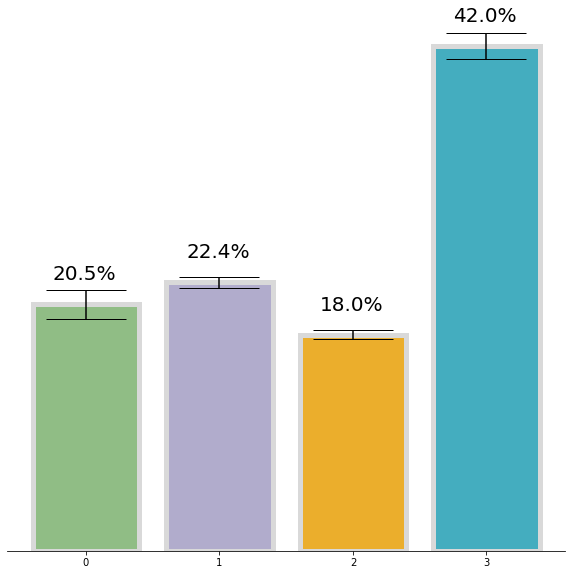

In [206]:
import matplotlib.colors as mcolors
f, ax = plt.subplots(1,1, figsize=(10,10))
df_plot = pd.DataFrame({'Ex_rate':df_nos1_ex_rate.loc[bigmasks].mean(axis=1),
                       'Se':df_nos1_ex_rate.loc[bigmasks].sem(axis=1)})
ax.bar(data=df_plot, x=np.arange(0,4,1),
       height=df_plot['Ex_rate'],yerr=df_plot['Se'], 
       capsize=40, color=["#90BD85","#B1ACCC", "#EBAE2C", "#44ADBF"],edgecolor='#D9D9D9', linewidth=5)
ax.set_xticks(np.arange(0,4,1))
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
for i, v in enumerate(df_plot['Ex_rate']):
    ax.text(i-0.25,v+0.02, str(round(v*100,1))+'%', color='black', fontsize=20)

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


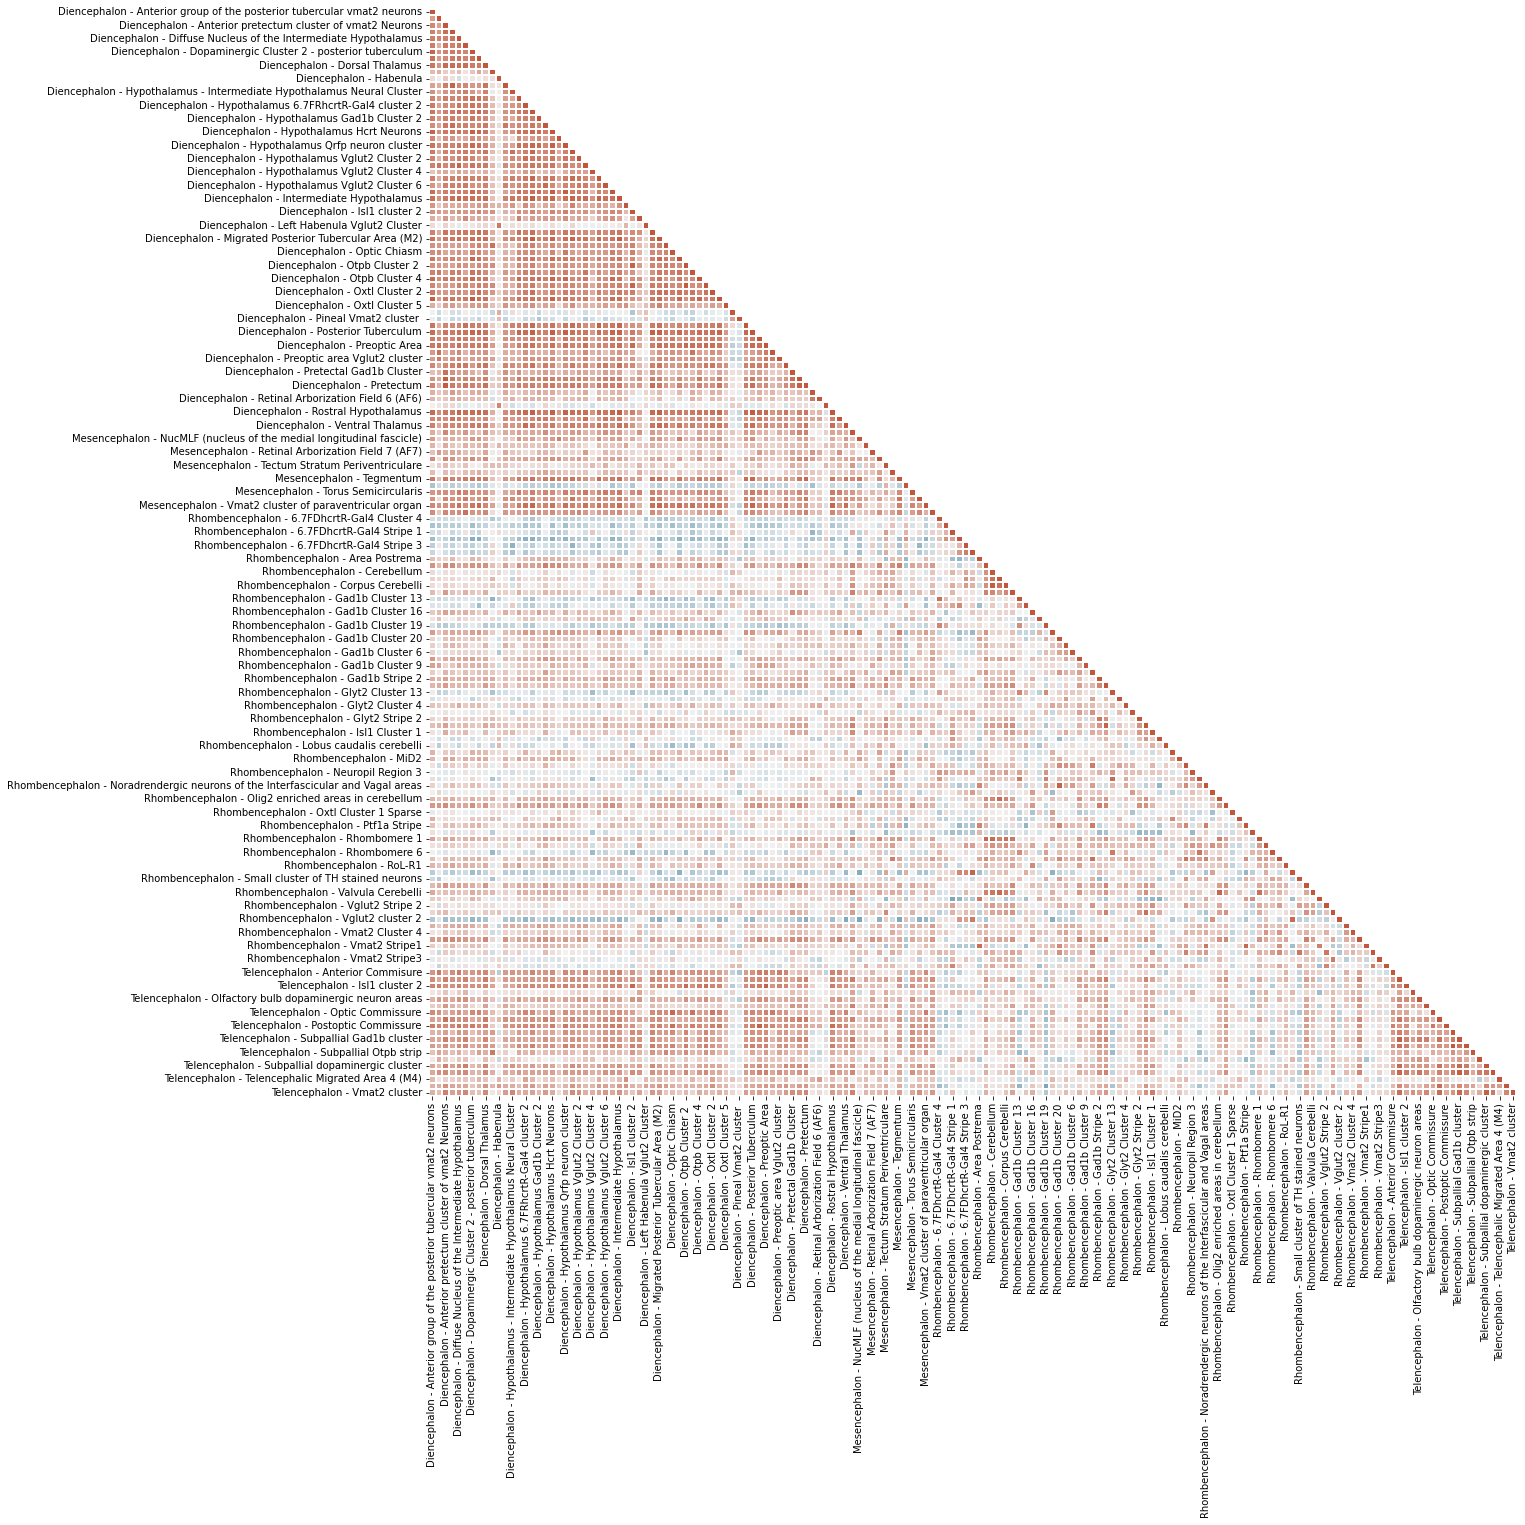

In [233]:
f, ax=plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_corr.where(np.tril(np.ones(df_corr.shape)).astype(np.bool)), 
            cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": 0.8,'label':'Corr.Coeff.'}, \
            annot=None,annot_kws={'fontsize':12}, ax=ax, cbar=False)
plt.show()

### analyze correlation of nos1 expression in re-nos1 KO

In [831]:
## decide the order of the mask in final presentaiton
## firt group by up and down then group by anatomical mask no. 
ko_nos1masklist = pd.read_excel('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/Table S9 HCR spatial expression data in re-nos1 KO vs sibs.xlsx',
                                 skiprows=3, nrows=5, header=None)
df_temp1 = ko_nos1masklist.loc[ko_nos1masklist[6]=='KO_up'].sort_values(1)
df_temp2 = ko_nos1masklist.loc[ko_nos1masklist[6]=='KO_down'].sort_values(1)
ko_nos1masklist = pd.concat((df_temp1, df_temp2))
ko_nos1masklist

,0,1,2,3,4,5,6
3,Diencephalon - Medial vglut2 cluster,40,0.007040,0.007125,0.043764,0.043523,KO_up
4,Diencephalon - Posterior Tuberculum,58,0.066084,0.018637,0.069909,0.046391,KO_up
1,Rhombencephalon - Anterior Cluster of nV Trige...,124,0.016332,0.099669,0.046306,0.085982,KO_down
0,Rhombencephalon - Gad1b Stripe 3,157,0.006918,0.056218,0.043894,0.068260,KO_down
2,Rhombencephalon - Oxtl Cluster 2 Near MC axon cap,212,0.027058,0.189845,0.047930,0.135808,KO_down


In [778]:
## use the organized mask order to perform correlation analysis
df_nos1_pcorr_input  = df_nos1_ex_rate.copy().dropna()
df_nos1_pcorr_input  = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.isin(bigmasks)]
df_nos1_pcorr_input  = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.str.contains('Ganglia')]
df_nos1_pcorr_input  = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.str.contains('Spinal Cord')]
df_temp1 = df_nos1_pcorr_input .loc[df_nos1_pcorr_input .index.isin(ko_nos1masklist[0])]
df_temp2 = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.isin(ko_nos1masklist[0])]
df_nos1_pcorr_input  = pd.concat((df_temp1,df_temp2))
df_nos1_corr_pval = df_nos1_pcorr_input .transpose().dropna().rcorr(padjust='fdr_bh',stars=True)

## compute number of masks with signficant nos1 exp. correlation

In [1048]:
## count numbe of masks with postive and negative nos1 expression correlation
df_temp1 = df_nos1_corr_pval.where(np.tril(np.ones(df_nos1_corr_pval.shape)).astype(np.bool)).stack()
df_temp1 = df_temp1.loc[~(df_temp1=='-')].astype(float)
index_temp1 = df_temp1.loc[df_temp1>0].index
index_temp3 = df_temp1.loc[df_temp1<0].index

df_temp2 = df_nos1_corr_pval.transpose().where(np.tril(np.ones(df_nos1_corr_pval.transpose().shape)).astype(np.bool)).stack()
index_temp2 = df_temp2.loc[df_temp2.str.startswith('*')].index
print(len(index_temp2.intersection(index_temp1)))
print(len(index_temp2.intersection(index_temp3)))



/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


5201
304


In [1046]:
## count numbe of masks with postive and negative vglut2.2 expression correlation
df_temp1 = df_vglut_corr_pval.where(np.tril(np.ones(df_nos1_corr_pval.shape)).astype(np.bool)).stack()
df_temp1 = df_temp1.loc[~(df_temp1=='-')].astype(float)
index_temp1 = df_temp1.loc[df_temp1>0].index
index_temp3 = df_temp1.loc[df_temp1<0].index

df_temp2 = df_nos1_corr_pval.transpose().where(np.tril(np.ones(df_nos1_corr_pval.transpose().shape)).astype(np.bool)).stack()
index_temp2 = df_temp2.loc[df_temp2.str.startswith('*')].index
print(len(index_temp2.intersection(index_temp1)))
print(len(index_temp2.intersection(index_temp3)))

4068
1197


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [1054]:
## export correlation of nos1 and vglut2
df_export = df_nos1_corr_pval.copy()
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/HCR/HCR_analysis/'
df_export.to_csv(wdir+'nos1_hcr_corr_20230819.csv')

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [1057]:
## export correlation of nos1 and vglut2
df_export = df_vglut_corr_pval.copy()
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/HCR/HCR_analysis/'
df_export.to_csv(wdir+'vglut2.2_hcr_corr_20230819.csv')

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [779]:
df_export = df_nos1_corr_pval[ko_nos1masklist[0]].loc[ko_nos1masklist[0]]
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
df_export.columns = df_export.index = ko_nos1masklist[1].astype(str)+' '+ko_nos1masklist[0]

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [780]:
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/HCR/HCR_analysis/'
df_export.to_csv(wdir+'ko_sigmask_nos1_hcr_corr_20230819.csv')


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Use the colorbar set_ticks() method instead.
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


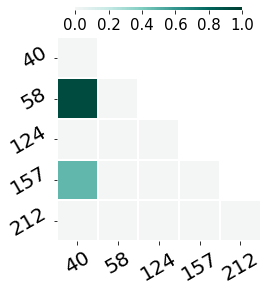

In [911]:
df_plot = df_nos1_corr_pval[ko_nos1masklist[0]].loc[ko_nos1masklist[0]]
for i in range (df_plot.shape[0]):
    df_plot.iloc[i,i] = 0
    for j in range (i+1, df_plot.shape[1]):
        if ("*" not in df_plot.iloc[i,j]):
            
            df_plot.iloc[j,i] = 0
        df_plot.iloc[i,j] = 0
df_plot = df_plot.astype(float)
df_plot.columns = df_plot.index = ko_nos1masklist[1]

# Draw the heatmap
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(df_plot.where(np.tril(np.ones(df_plot.shape)).astype(np.bool)), 
            cmap='BrBG', vmax=1, vmin=0, center=0,
            square=True, linewidths=.1, 
            cbar_kws={"shrink": 0.6,
                      'label':'',
                      'pad':0.1, 
                      'location':'top',
                     'aspect':50}, 
            annot=None, annot_kws={'fontsize':12}, ax=ax)

fontsize = 20
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,horizontalalignment='center', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30,horizontalalignment='right',fontsize=fontsize)
ax.set_ylabel('')
ax.set_xlabel('')
ax.figure.axes[-1].xaxis.label.set_size(fontsize)
#ax.figure.axes[-1].set_xticklabels(ax.figure.axes[-1].get_xticklabels(),fontsize=10)
ax.figure.axes[-1].set_xticks(np.arange(0,1.2,0.2),fontsize=15)
ax.figure.axes[-1].set_xticklabels(np.arange(0,1.2,0.2).round(1),fontsize=15)
ax.figure.axes[-1].xaxis.tick_bottom()
plt.show()

In [913]:
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/'
f.savefig(wdir+'Figure 6B.tiff', dpi=300, bbox_inches='tight')


### analyze correlation of nos1 expression in SV

In [739]:
## decide the order of the mask in final presentaiton
## firt group by up and down then group by anatomical mask no. 
sv_nos1masklist = pd.read_excel('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/Table S9 HCR spatial expression data in SDA vs VDA.xlsx',
                                 skiprows=3, nrows=26, header=None)
df_temp1 = sv_nos1masklist.loc[sv_nos1masklist[6]=='SDA_up'].sort_values(1)
df_temp2 = sv_nos1masklist.loc[sv_nos1masklist[6]=='SDA_down'].sort_values(1)
sv_nos1masklist = pd.concat((df_temp1, df_temp2))
sv_nos1masklist

,0,1,2,3,4,5,6
12,Diencephalon - Dopaminergic Cluster 1 - ventra...,7,0.164607,0.026788,0.112869,0.049401,SDA_up
2,Diencephalon - Hypothalamus Gad1b Cluster 1,20,0.005162,0.012591,0.030196,0.037027,SDA_up
10,Diencephalon - Hypothalamus Vglut2 Cluster 5,31,0.029148,0.027844,0.053393,0.043286,SDA_up
5,Diencephalon - Medial vglut2 cluster,40,0.010566,0.029478,0.046068,0.057670,SDA_up
4,Diencephalon - Pineal,55,0.009954,0.027493,0.040327,0.050880,SDA_up
8,Diencephalon - Pineal Vmat2 cluster,56,0.034138,0.018174,0.051588,0.033398,SDA_up
9,Diencephalon - Pituitary,57,0.029836,0.016249,0.051689,0.025601,SDA_up
0,Diencephalon - Posterior Tuberculum,58,0.003234,0.012006,0.023671,0.024308,SDA_up
11,Diencephalon - Preoptic area posterior dopamin...,63,0.083098,0.023699,0.084954,0.027084,SDA_up
1,Diencephalon - Rostral Hypothalamus,74,0.004298,0.006010,0.029596,0.018483,SDA_up


In [742]:
## use the organized mask order to perform correlation analysis
df_nos1_pcorr_input  = df_nos1_ex_rate.copy().dropna()
df_nos1_pcorr_input  = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.isin(bigmasks)]
df_nos1_pcorr_input  = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.str.contains('Ganglia')]
df_nos1_pcorr_input  = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.str.contains('Spinal Cord')]
df_temp1 = df_nos1_pcorr_input .loc[df_nos1_pcorr_input .index.isin(sv_nos1masklist[0])]
df_temp2 = df_nos1_pcorr_input .loc[~df_nos1_pcorr_input .index.isin(sv_nos1masklist[0])]
df_nos1_pcorr_input  = pd.concat((df_temp1,df_temp2))
df_nos1_corr_pval = df_nos1_pcorr_input .transpose().dropna().rcorr(padjust='fdr_bh',stars=True)

In [762]:
df_export = df_nos1_corr_pval[sv_nos1masklist[0]].loc[sv_nos1masklist[0]]
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
df_export.columns = df_export.index = sv_nos1masklist[1].astype(str)+' '+sv_nos1masklist[0]

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [763]:
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/HCR/HCR_analysis/'
df_export.to_csv(wdir+'sv_sigmask_nos1_hcr_corr_20230819.csv')


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


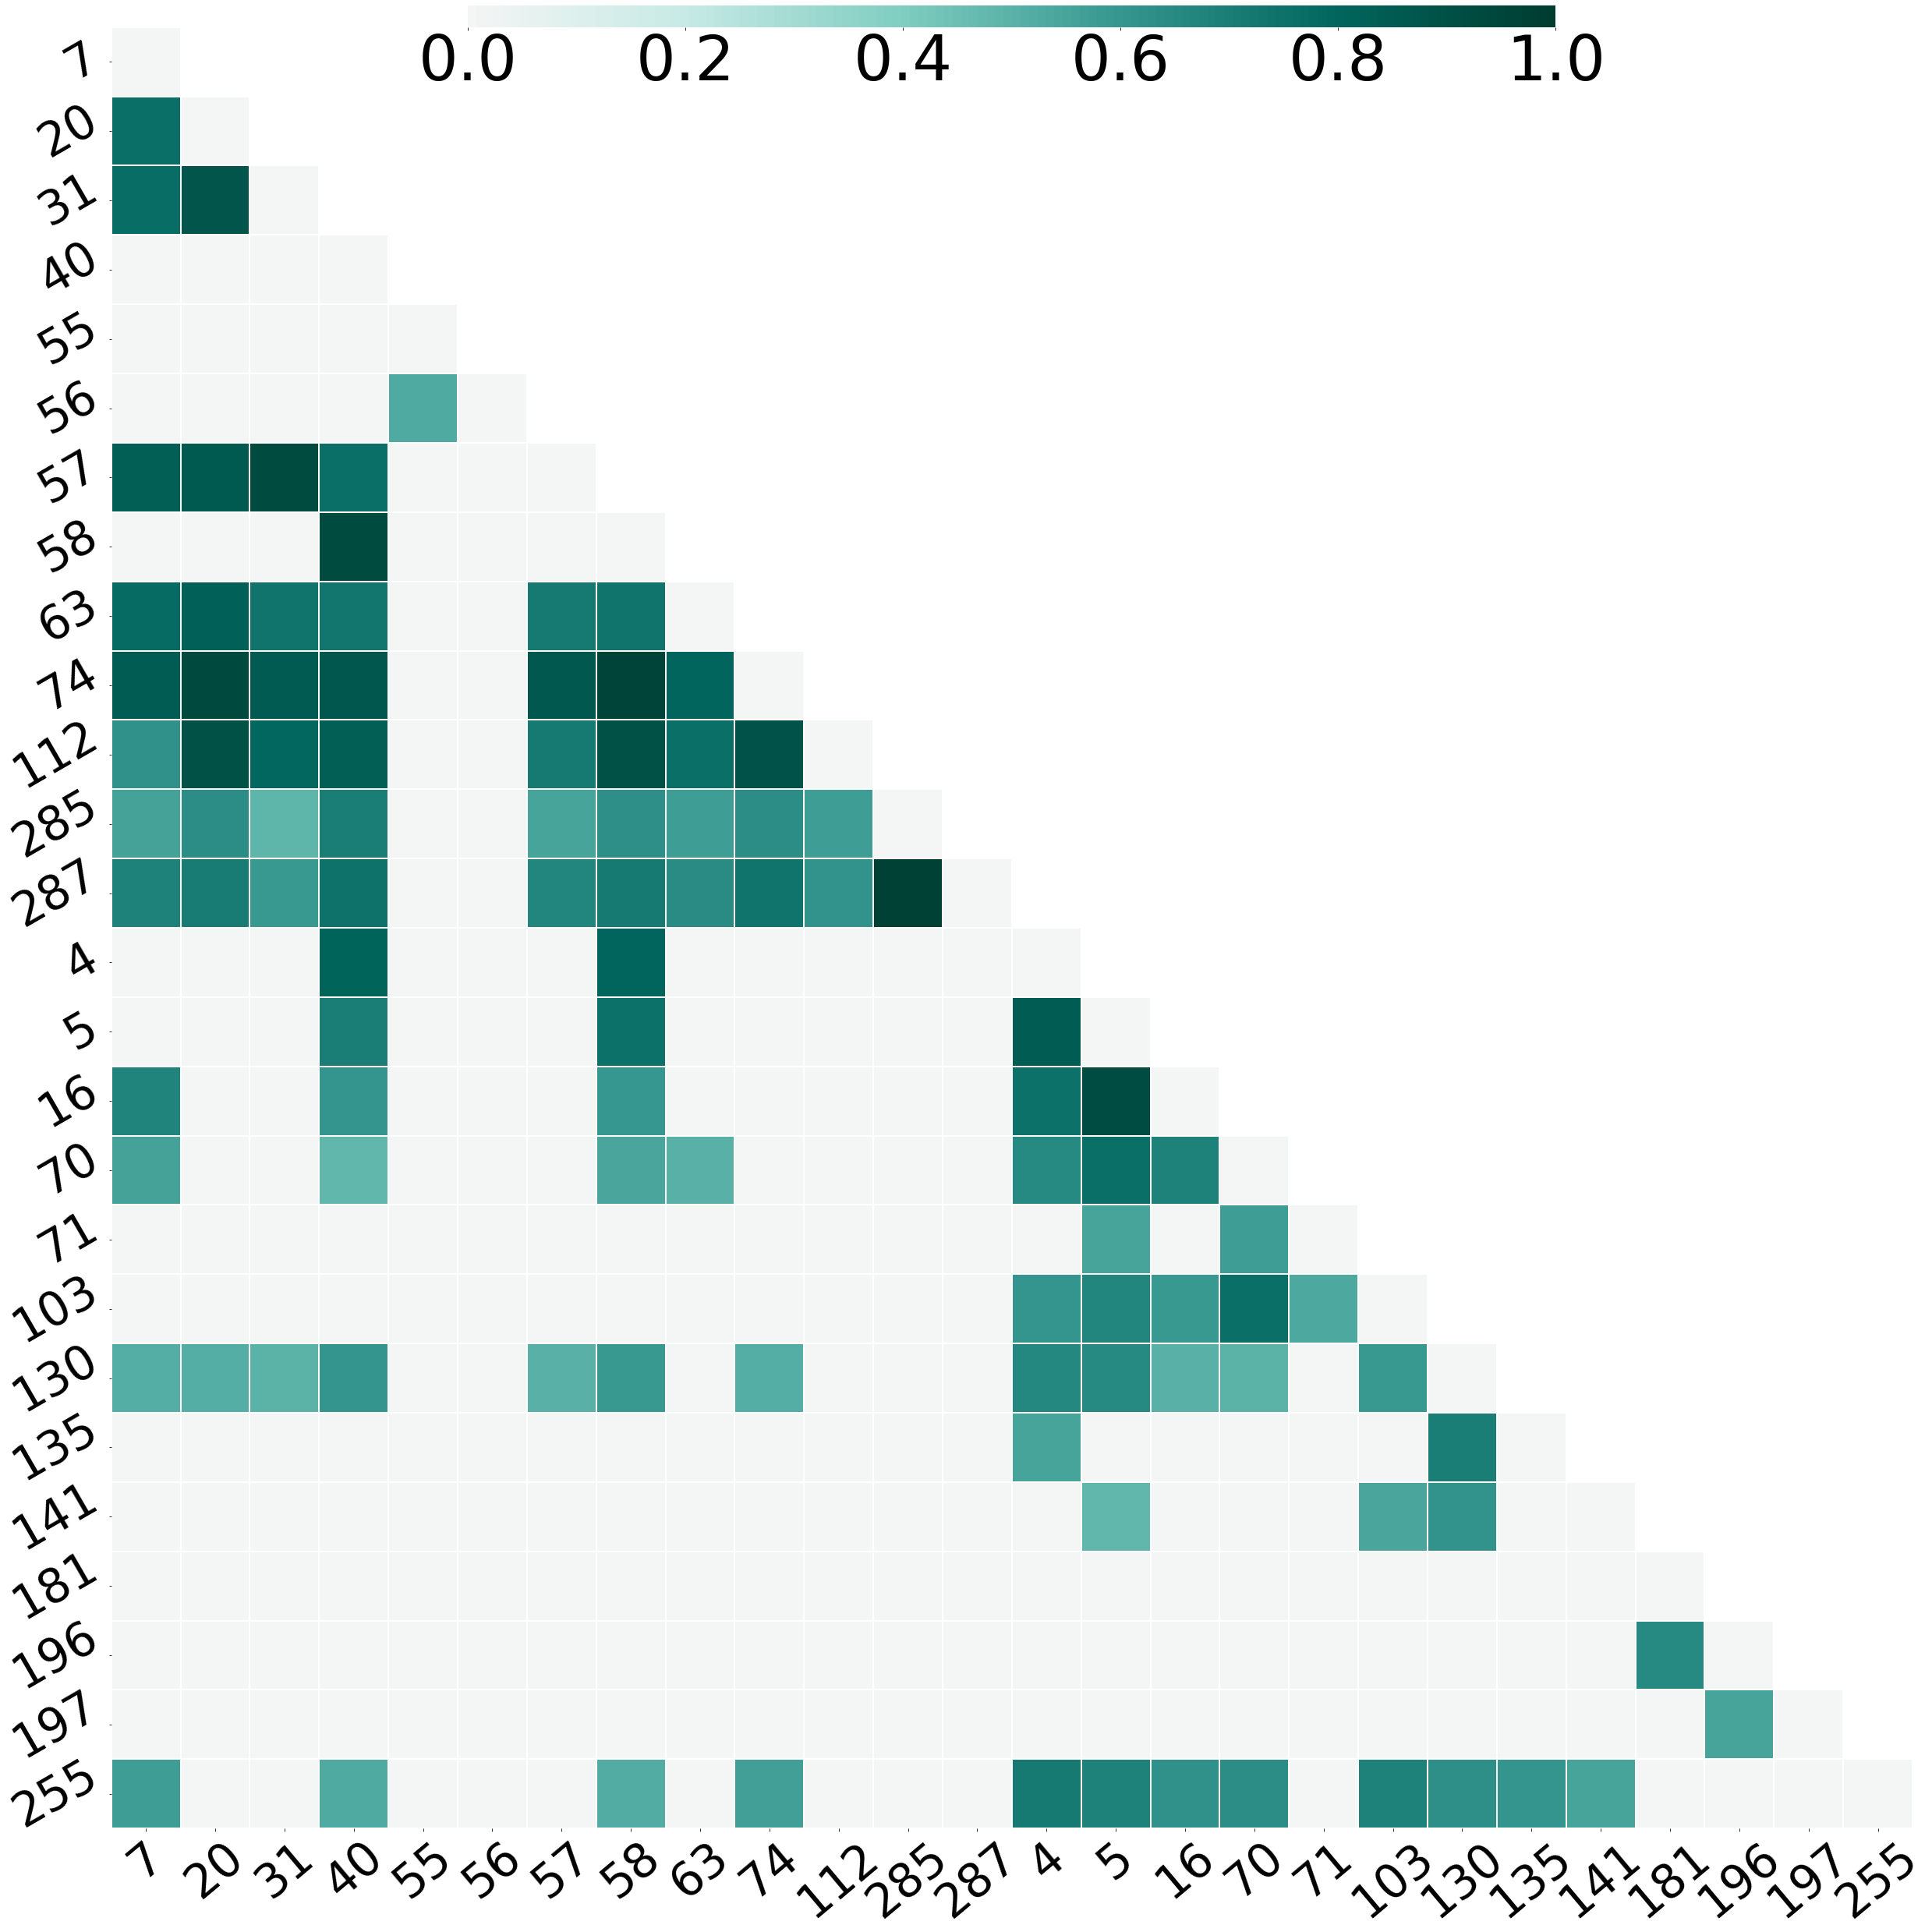

In [923]:
df_plot = df_nos1_corr_pval[sv_nos1masklist[0]].loc[sv_nos1masklist[0]]
for i in range (df_plot.shape[0]):
    df_plot.iloc[i,i] = 0
    for j in range (i+1, df_plot.shape[1]):
        if ("*" not in df_plot.iloc[i,j]):
            
            df_plot.iloc[j,i] = 0
        df_plot.iloc[i,j] = 0
df_plot = df_plot.astype(float)
df_plot.columns = df_plot.index = sv_nos1masklist[1]

# Draw the heatmap
f, ax=plt.subplots(figsize=(50,50))
sns.heatmap(df_plot.where(np.tril(np.ones(df_plot.shape)).astype(np.bool)), 
            cmap='BrBG', vmax=1, vmin=0, center=0,
            square=True, linewidths=.1, 
            cbar_kws={"shrink": 0.5,
                      'label':'',
                      'pad':0.00, 
                      'location':'top',
                     'aspect':50}, 
            annot=None, annot_kws={'fontsize':12}, ax=ax)

fontsize = 60
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,horizontalalignment='center', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30,horizontalalignment='right',fontsize=fontsize)
ax.set_ylabel('')
ax.set_xlabel('')
ax.figure.axes[-1].xaxis.label.set_size(fontsize)
ax.figure.axes[-1].xaxis.label
ax.figure.axes[-1].set_xticklabels(ax.figure.axes[-1].get_xticklabels(),fontsize=80)
ax.figure.axes[-1].xaxis.tick_bottom()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


In [925]:
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/'
f.savefig(wdir+'Figure 7E.tiff', dpi=600, bbox_inches='tight')

### analyze correlation of vglut2.2 expression in SV

In [764]:
## decide the order of the mask in final presentaiton
## firt group by up and down then group by anatomical mask no. 
sv_vglutmasklist = pd.read_excel('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/Table S9 HCR spatial expression data in SDA vs VDA.xlsx',
                                 sheet_name = 3, skiprows=3, nrows=6, header=None)
df_temp1 = sv_vglutmasklist.loc[sv_vglutmasklist[6]=='SDA_up'].sort_values(1)
df_temp2 = sv_vglutmasklist.loc[sv_vglutmasklist[6]=='SDA_down'].sort_values(1)
sv_vglutmasklist = pd.concat((df_temp1, df_temp2))
sv_vglutmasklist

,0,1,2,3,4,5,6
1,Diencephalon - Dopaminergic Cluster 4/5 - post...,10,0.000540,0.000897,0.008690,0.049440,SDA_up
2,Diencephalon - Pineal,55,0.002227,0.011881,0.019364,0.052669,SDA_up
3,Diencephalon - Pineal Vmat2 cluster,56,0.009139,0.005626,0.042990,0.048354,SDA_up
4,Rhombencephalon - Gad1b Cluster 13,139,0.004297,0.000434,0.027001,0.042361,SDA_up
5,Telencephalon - Vmat2 cluster,294,0.445966,0.011926,0.500411,0.044250,SDA_up
0,Rhombencephalon - MiD3,188,0.084693,0.074307,0.059419,0.047916,SDA_down


In [770]:
## use the organized mask order to perform correlation analysis
df_vglut_pcorr_input  = df_vglu2b_ex_rate.copy().dropna()
df_vglut_pcorr_input  = df_vglut_pcorr_input .loc[~df_vglut_pcorr_input .index.isin(bigmasks)]
df_vglut_pcorr_input  = df_vglut_pcorr_input .loc[~df_vglut_pcorr_input .index.str.contains('Ganglia')]
df_vglut_pcorr_input  = df_vglut_pcorr_input .loc[~df_vglut_pcorr_input .index.str.contains('Spinal Cord')]
df_temp1 = df_vglut_pcorr_input .loc[df_vglut_pcorr_input .index.isin(sv_vglutmasklist[0])]
df_temp2 = df_vglut_pcorr_input .loc[~df_vglut_pcorr_input .index.isin(sv_vglutmasklist[0])]
df_vglut_pcorr_input  = pd.concat((df_temp1,df_temp2))
df_vglut_corr_pval = df_vglut_pcorr_input .transpose().dropna().rcorr(padjust='fdr_bh',stars=True)

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [771]:
df_export = df_vglut_corr_pval[sv_vglutmasklist[0]].loc[sv_vglutmasklist[0]]
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
df_export.columns = df_export.index = sv_vglutmasklist[1].astype(str)+' '+sv_vglutmasklist[0]

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [772]:
wdir = '/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/experiments/HCR/HCR_analysis/'
df_export.to_csv(wdir+'sv_sigmask_vglut_hcr_corr_20230819.csv')

### correlation between vlgut and nos1 expression

In [436]:
ex_count_list = []
for fish in dic_vglu2b_90.keys():
    ex_count_list.append(dic_vglu2b_90[fish]['ex_count'])
df_vglu2b_ex = pd.concat(ex_count_list,axis=1)
df_vglu2b_ex.columns = dic_vglu2b_90.keys()
df_vglu2b_ex = pd.concat((df_vglu2b_ex,df_mask_volume),axis=1)
df_vglu2b_ex.rename(columns = {0:'total'}, inplace=True)
df_vglu2b_ex = df_vglu2b_ex[metadata.loc[metadata.sort_values('Geno')['Fish_id'].isin(list(dic_vglu2b_90.keys()))]['Fish_id'].to_list()+['total']]


In [881]:
df_nos1_ex_new = df_nos1_ex.copy()
df_vglut_ex_new = df_vglu2b_ex.copy()

df_nos1_ex_new['gmean'] = stats.gmean(df_nos1_ex_new,axis=1)
df_nos1_ex_new = df_nos1_ex_new.loc[~(df_nos1_ex_new['gmean']==0)]
df_vglut_ex_new['gmean'] = stats.gmean(df_vglut_ex_new,axis=1)
df_vglut_ex_new = df_vglut_ex_new.loc[~(df_vglut_ex_new['gmean']==0)]

shared_index = df_nos1_ex_new.dropna().index.intersection(df_vglu2b_ex_new.dropna().index).drop(bigmasks)
df_nos1_ex_new = df_nos1_ex.dropna().loc[shared_index]
df_vglu2b_ex_new = df_vglu2b_ex.dropna().loc[shared_index]


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [882]:
corr_ce_list = []
corr_pv_list = []
for i in range (0, df_nos1_ex_new.shape[0]):
    corr_ce_single = []
    corr_pv_single = []
    x = df_nos1_ex_new.iloc[i,:-1]
    for j in range (0, df_vglu2b_ex_new.shape[0]):
        y = df_vglu2b_ex_new.iloc[j,:-1]
        corr_ce = pg.corr(x, y).iloc[0,1]
        corr_pv = pg.corr(x, y).iloc[0,3]
        corr_ce_single.append(corr_ce)
        corr_pv_single.append(corr_pv)
    corr_ce_list.append(corr_ce_single)
    corr_pv_list.append(corr_pv_single)
df_corr_ce_nos1_2_vlgut = pd.DataFrame(corr_ce_list)
df_corr_pv_nos1_2_vlgut = pd.DataFrame(corr_pv_list)


In [883]:
df_corr_ce_nos1_2_vlgut = pd.DataFrame(corr_ce_list)
df_corr_pv_nos1_2_vlgut = pd.DataFrame(corr_pv_list)

In [884]:
def padj_fdr(row):
    return pg.multicomp(row)[1]
df_corr_padj_nos1_2_vlgut = df_corr_pv_nos1_2_vlgut.transpose().apply(padj_fdr).transpose()

In [885]:
df_corr_padj_nos1_2_vlgut.columns = df_corr_padj_nos1_2_vlgut.index = shared_index
df_corr_ce_nos1_2_vlgut.columns = df_corr_ce_nos1_2_vlgut.index = shared_index

In [929]:
df_corr_ce_nos1_2_vlgut

,Diencephalon - Anterior preoptic dopaminergic cluster,Diencephalon - Anterior pretectum cluster of vmat2 Neurons,Diencephalon - Caudal Hypothalamus,Diencephalon - Diffuse Nucleus of the Intermediate Hypothalamus,Diencephalon - Dopaminergic Cluster 1 - ventral thalamic and periventricular posterior tubercular DA neurons,Diencephalon - Dopaminergic Cluster 3 - hypothalamus,Diencephalon - Dopaminergic Cluster 4/5 - posterior tuberculum and hypothalamus,Diencephalon - Dopaminergic Cluster 6 - hypothalamus,Diencephalon - Dopaminergic Cluster 7 - Caudal Hypothalamus,Diencephalon - Dorsal Thalamus,...,Telencephalon - S1181t Cluster,Telencephalon - Subpallial Gad1b cluster,Telencephalon - Subpallial Otpb Cluster 2,Telencephalon - Subpallial Otpb strip,Telencephalon - Subpallial Vglut2 Cluster,Telencephalon - Subpallial dopaminergic cluster,Telencephalon - Subpallium,Telencephalon - Telencephalic Migrated Area 4 (M4),Telencephalon - Vglut2 rind,Telencephalon - Vmat2 cluster
Diencephalon - Anterior preoptic dopaminergic cluster,0.693708,0.294254,0.315155,0.296082,0.202797,0.440083,0.245040,-0.144697,0.173834,0.405541,...,0.167625,0.145355,0.065100,0.480544,0.483014,0.010167,0.509196,-0.029893,-0.070406,0.132562
Diencephalon - Anterior pretectum cluster of vmat2 Neurons,0.395091,0.557916,0.475698,0.477266,0.440446,0.286993,0.413221,-0.263256,0.085776,0.528878,...,0.356197,-0.130153,0.378342,0.146411,0.012807,-0.063374,0.138953,0.131527,-0.148529,0.108466
Diencephalon - Caudal Hypothalamus,0.473242,0.488191,0.711523,0.519731,0.310032,0.306401,0.382438,-0.048070,0.223710,0.534353,...,0.392842,-0.065993,0.412411,0.385209,-0.021129,-0.151118,0.181865,0.208186,-0.079909,0.011800
Diencephalon - Diffuse Nucleus of the Intermediate Hypothalamus,0.617682,0.531782,0.552724,0.704835,0.437188,0.503626,0.586394,-0.249583,0.302096,0.620926,...,0.388389,-0.059373,0.391648,0.407043,0.116383,-0.020450,0.271258,0.171058,-0.215857,0.190863
Diencephalon - Dopaminergic Cluster 1 - ventral thalamic and periventricular posterior tubercular DA neurons,0.399374,0.412492,0.470801,0.532636,0.409511,0.317507,0.466447,-0.127140,0.172879,0.454161,...,0.313884,-0.109198,0.390149,0.102408,-0.012399,-0.017073,0.115217,0.220256,-0.261161,0.166724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Telencephalon - Subpallial dopaminergic cluster,0.244182,0.333713,0.363593,0.460721,0.341589,0.148990,0.369428,-0.437941,0.019318,0.331535,...,0.395807,-0.108968,0.473841,0.172935,-0.044804,0.056847,0.178480,0.081564,-0.040264,0.177785
Telencephalon - Subpallium,0.390005,0.241370,0.210893,0.238388,0.269579,0.200110,0.196799,-0.436020,-0.029475,0.303497,...,0.327909,0.194893,0.312806,0.297104,0.419582,0.241581,0.571922,-0.216074,0.190682,0.348880
Telencephalon - Telencephalic Migrated Area 4 (M4),0.279767,0.530791,0.133856,0.338387,0.153028,0.144731,0.518107,0.169805,0.231845,0.370406,...,0.107359,-0.377704,0.274624,0.088367,-0.469606,-0.453241,-0.395898,0.876460,-0.427061,-0.408563
Telencephalon - Vglut2 rind,0.335866,0.491628,0.352184,0.345763,0.196729,0.190933,0.420459,-0.135443,0.242014,0.400982,...,0.287541,-0.219419,0.368915,0.234448,-0.187860,-0.259880,0.017484,0.353082,-0.096909,-0.163378


In [943]:
index_temp1 = df_corr_ce_nos1_2_vlgut.stack().loc[df_corr_ce_nos1_2_vlgut.stack()<0].index

In [944]:
index_temp2 = df_corr_padj_nos1_2_vlgut.stack().loc[df_corr_padj_nos1_2_vlgut.stack()<0.05].index

In [946]:
len(index_temp1.intersection(index_temp2))

32

In [886]:
def symbolize_pval(pval):
    if pval>0.05:
        return 'ns'
    elif pval<0.05 and pval>0.01:
        return '*'
    elif pval>0.00001:
        return '*'*(round(math.log(pval,10)*(-1)))
    else:
        return '*'*5

In [892]:
df_corr_nos1_2_vlgut_symbol = df_corr_padj_nos1_2_vlgut.applymap(symbolize_pval)
df_export = df_corr_ce_nos1_2_vlgut.round(3).astype(str)+df_corr_nos1_2_vlgut_symbol
df_export = df_export.applymap(lambda x: 'ns' if 'ns' in x else x)
#df_export.index = sv_nos1masklist[1].astype(str)+' '+sv_nos1masklist[0]
#df_export.columns = sv_vglutmasklist[1].astype(str)+' '+sv_vglutmasklist[0]
df_export.to_csv(wdir+'nos1_2_vlgut_corr_20230819.csv')

In [875]:
df_sv_nos1_2_vlgut_pval = df_corr_padj_nos1_2_vlgut.loc[sv_nos1masklist[0], sv_vglutmasklist[0]]
df_sv_ce_nos1_2_vlgut = df_corr_ce_nos1_2_vlgut.loc[sv_nos1masklist[0], sv_vglutmasklist[0]]
df_sv_nos1_2_vlgut_symbol = df_sv_nos1_2_vlgut_pval.applymap(symbolize_pval)


In [820]:
df_export = df_sv_ce_nos1_2_vlgut.round(3).astype(str)+df_sv_nos1_2_vlgut_symbol
df_export = df_export.applymap(lambda x: 'ns' if 'ns' in x else x)
df_export.index = sv_nos1masklist[1].astype(str)+' '+sv_nos1masklist[0]
df_export.columns = sv_vglutmasklist[1].astype(str)+' '+sv_vglutmasklist[0]
df_export.to_csv(wdir+'sv_nos1_2_vlgut_corr_20230819.csv')

In [834]:
ko_vglutmasklist = pd.read_excel('/Users/jialexu/Desktop/Project2GWAS-BehvaioralGenetics/doc/Figures/Initial_submit/Table S9 HCR spatial expression data in re-nos1 KO vs sibs.xlsx',
                                 sheet_name = 3, skiprows=3, nrows=3, header=None)
df_temp1 = ko_vglutmasklist.loc[ko_vglutmasklist[6]=='KO_up'].sort_values(1)
df_temp2 = ko_vglutmasklist.loc[ko_vglutmasklist[6]=='KO_down'].sort_values(1)
ko_vglutmasklist = pd.concat((df_temp1, df_temp2))
ko_vglutmasklist 

,0,1,2,3,4,5,6
2,Telencephalon - Olfactory bulb dopaminergic ne...,280,0.008496,0.015236,0.043244,0.044546,KO_up
0,Rhombencephalon - Gad1b Cluster 1,135,0.017185,0.038523,0.047319,0.057103,KO_down
1,Telencephalon - Olig2 Cluster,281,0.097384,0.008161,0.083860,0.045803,KO_down


In [846]:
df_ko_nos1_2_vlgut_pval = df_corr_padj_nos1_2_vlgut.loc[ko_nos1masklist[0], ko_vglutmasklist[0]]
df_ko_ce_nos1_2_vlgut = df_corr_ce_nos1_2_vlgut.loc[ko_nos1masklist[0], ko_vglutmasklist[0]]
df_ko_nos1_2_vlgut_symbol = df_ko_nos1_2_vlgut_pval.applymap(symbolize_pval)

In [852]:
df_export = df_ko_ce_nos1_2_vlgut.round(3).astype(str)+df_ko_nos1_2_vlgut_symbol
df_export = df_export.applymap(lambda x: 'ns' if 'ns' in x else x)
df_export.index = ko_nos1masklist[1].astype(str)+' '+ko_nos1masklist[0]
df_export.columns = ko_vglutmasklist[1].astype(str)+' '+ko_vglutmasklist[0]
df_export.to_csv(wdir+'ko_nos1_2_vlgut_corr_20230819.csv')

In [615]:
dic = {}
for fish in (df_vglu2b_ex.iloc[:,:-1].columns):
    dic.update({fish:df_vglu2b_ex[fish]/df_vglu2b_ex['total']})
df_vglu2b_ex_rate = pd.DataFrame(dic)
df_pcorr_input = df_vglu2b_ex_rate.copy().dropna()
#df_pcorr_input = df_nos1_ex_rate.loc[df_nos1_ex_rate.mean(axis=1)>0.1]
df_pcorr_input = df_pcorr_input.loc[~df_pcorr_input.index.isin(bigmasks)]
df_pcorr_input = df_pcorr_input.loc[~df_pcorr_input.index.str.contains('Ganglia')]
df_pcorr_input = df_pcorr_input.loc[~df_pcorr_input.index.str.contains('Spinal Cord')]


In [625]:
df_vglu2b_corr_pval = df_pcorr_input.transpose().dropna().rcorr(padjust='fdr_bh',stars=True)


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [623]:
df_export = df_vglu2b_corr_pval[sorted(ko_vglumasklist)].loc[sorted(ko_vglumasklist)]
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
df_export.to_csv(wdir+'ko_sigmask_vglut_hcr_corr_20230819.csv')

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


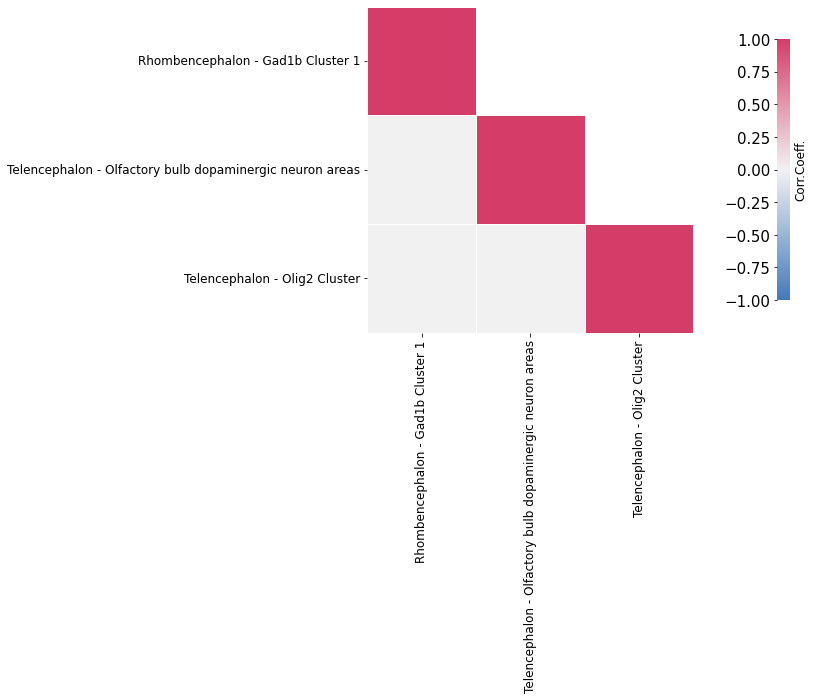

In [630]:
df_plot = df_vglu2b_corr_pval[sorted(ko_vglumasklist)].loc[sorted(ko_vglumasklist)]
for i in range (df_plot.shape[0]):
    df_plot.iloc[i,i] = 1
    for j in range (i+1, df_plot.shape[1]):
        if ("*" not in df_plot.iloc[i,j]):
            
            df_plot.iloc[j,i] = 0
        df_plot.iloc[i,j] = 0
df_plot = df_plot.astype(float)
cmap = sns.diverging_palette(250, 0, as_cmap=True)

# Draw the heatmap
f, ax=plt.subplots(figsize=(30,6))
sns.heatmap(df_plot.where(np.tril(np.ones(df_plot.shape)).astype(np.bool)), 
            cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8,'label':'Corr.Coeff.'}, annot=None, annot_kws={'fontsize':12}, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,horizontalalignment='center', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,horizontalalignment='right',fontsize=12)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=15)
ax.figure.axes[-1].yaxis.tick_left()

In [624]:
df_export = df_vglu2b_corr_pval[sorted(sv_vglumasklist)].loc[sorted(sv_vglumasklist)]
df_export = df_export.astype(str)+df_export.transpose().astype(str)
df_export = df_export.applymap(lambda x: x if ('*' in x or '--' in x ) else 'ns')

df_export = df_export.where(np.tril(np.ones(df_export.shape)).astype(np.bool)).fillna('')
df_export.to_csv(wdir+'sv_sigmask_vglut_hcr_corr_20230819.csv')

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


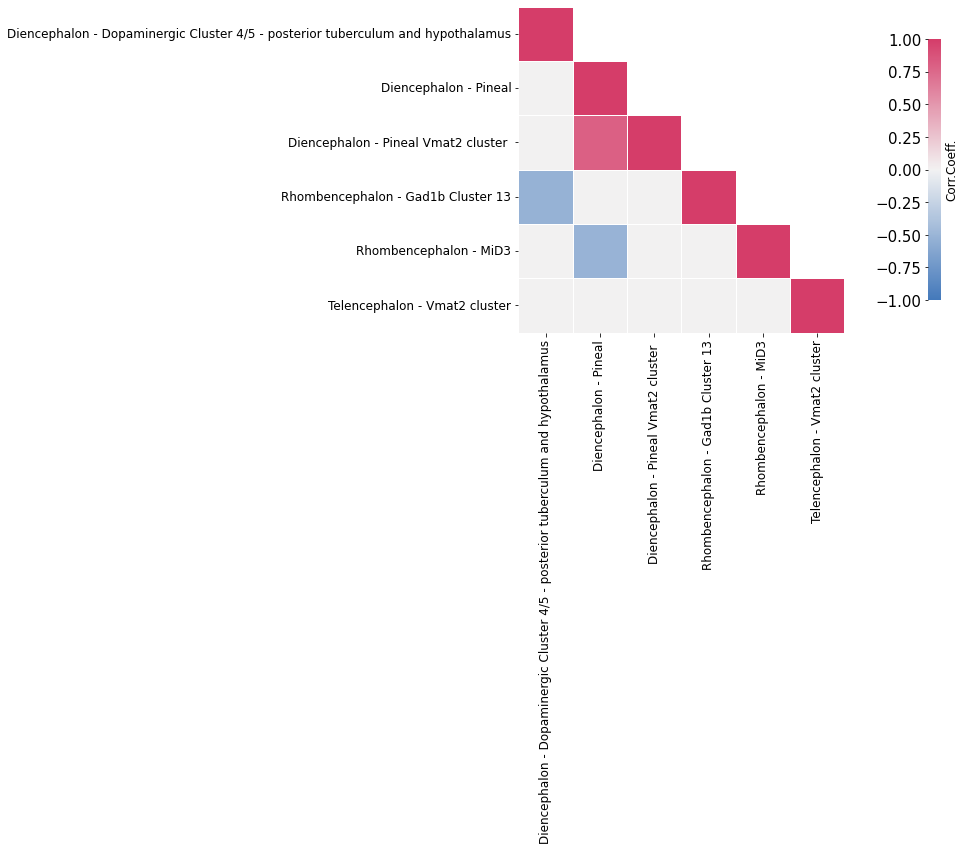

In [631]:
df_plot = df_vglu2b_corr_pval[sorted(sv_vglumasklist)].loc[sorted(sv_vglumasklist)]
for i in range (df_plot.shape[0]):
    df_plot.iloc[i,i] = 1
    for j in range (i+1, df_plot.shape[1]):
        if ("*" not in df_plot.iloc[i,j]):
            
            df_plot.iloc[j,i] = 0
        df_plot.iloc[i,j] = 0
df_plot = df_plot.astype(float)
cmap = sns.diverging_palette(250, 0, as_cmap=True)

# Draw the heatmap
f, ax=plt.subplots(figsize=(30,6))
sns.heatmap(df_plot.where(np.tril(np.ones(df_plot.shape)).astype(np.bool)), 
            cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8,'label':'Corr.Coeff.'}, annot=None, annot_kws={'fontsize':12}, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,horizontalalignment='center', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,horizontalalignment='right',fontsize=12)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=15)
ax.figure.axes[-1].yaxis.tick_left()